Ignore the line numbers, the notebook is created over several days, so I had to reimport some libraries and reinitialise some variable at different stage.

In [1]:
import tensorflow as tf

# Loading an image for demonstration

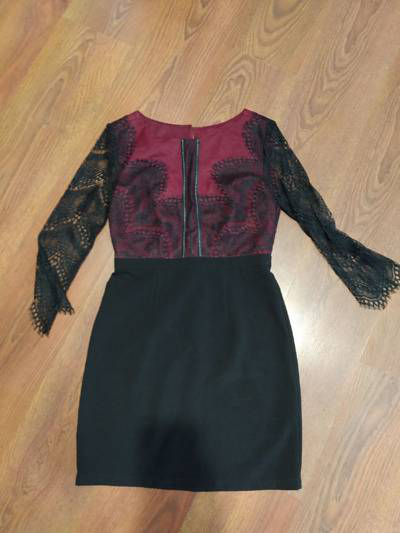

In [2]:
tf.keras.utils.load_img("clothing-dataset-small-master/train/dress/0d3cf39f-78f1-440e-9504-f510e75aff0b.jpg")

# We will use EfficientNetV2L for Transfer Learning

In [3]:
model = tf.keras.applications.efficientnet_v2.EfficientNetV2L()

In [4]:
img = tf.keras.utils.load_img("clothing-dataset-small-master/train/dress/0d3cf39f-78f1-440e-9504-f510e75aff0b.jpg", target_size=(480, 480))

In [5]:
import numpy as np

x = np.array(img)
x.shape

(480, 480, 3)

In [6]:
X = np.array([x])
X.shape

(1, 480, 480, 3)

In [7]:
X = tf.keras.applications.efficientnet_v2.preprocess_input(X)
pred = model.predict(X)
pred.shape

1/1 [==============================] - 11s 11s/step


(1, 1000)

In [8]:
tf.keras.applications.efficientnet_v2.decode_predictions(pred)

[[('n04525038', 'velvet', 0.49319676),
  ('n03866082', 'overskirt', 0.12797937),
  ('n04599235', 'wool', 0.10122795),
  ('n02963159', 'cardigan', 0.053907543),
  ('n03534580', 'hoopskirt', 0.020059705)]]

# Transfer Learning

In [3]:
image_size = (128,128)

In [4]:
train_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet_v2.preprocess_input)

train_ds = train_gen.flow_from_directory(
    "clothing-dataset-small-master/train",
    seed=0,
    target_size=image_size,
)

Found 3068 images belonging to 10 classes.


In [5]:
validation_ds = train_gen.flow_from_directory(
    "clothing-dataset-small-master/validation",
    seed=0,
    target_size=image_size,
)

Found 341 images belonging to 10 classes.


In [18]:
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2L(include_top=False, input_shape=(128,128,3))
base_model.trainable = False

In [28]:
# Whole Model

inputs = tf.keras.Input(shape=(128,128,3))
base = base_model(inputs, training=False)
vector = tf.keras.layers.MaxPool2D()(base)
flat = tf.keras.layers.Flatten()(vector)
outputs = tf.keras.layers.Dense(10)(flat)

model = tf.keras.Model(inputs, outputs)

In [29]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=["accuracy"])

In [30]:
history = model.fit(train_ds, epochs=10, validation_data=validation_ds)

Epoch 1/10
96/96 [==============================] - 199s 2s/step - loss: 0.8038 - accuracy: 0.7308 - val_loss: 0.5762 - val_accuracy: 0.8152
Epoch 2/10
96/96 [==============================] - 171s 2s/step - loss: 0.3801 - accuracy: 0.8667 - val_loss: 0.4883 - val_accuracy: 0.8475
Epoch 3/10
96/96 [==============================] - 163s 2s/step - loss: 0.2338 - accuracy: 0.9214 - val_loss: 0.4756 - val_accuracy: 0.8651
Epoch 4/10
96/96 [==============================] - 157s 2s/step - loss: 0.1572 - accuracy: 0.9514 - val_loss: 0.4975 - val_accuracy: 0.8534
Epoch 5/10
96/96 [==============================] - 153s 2s/step - loss: 0.1083 - accuracy: 0.9700 - val_loss: 0.4575 - val_accuracy: 0.8592
Epoch 6/10
96/96 [==============================] - 151s 2s/step - loss: 0.0769 - accuracy: 0.9879 - val_loss: 0.4558 - val_accuracy: 0.8739
Epoch 7/10
96/96 [==============================] - 155s 2s/step - loss: 0.0735 - accuracy: 0.9870 - val_loss: 0.4726 - val_accuracy: 0.8651
Epoch 8/10
96

In [31]:
model.save('Small_Dataset_Neural_Net.h5')

In [6]:
# Error handling

import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

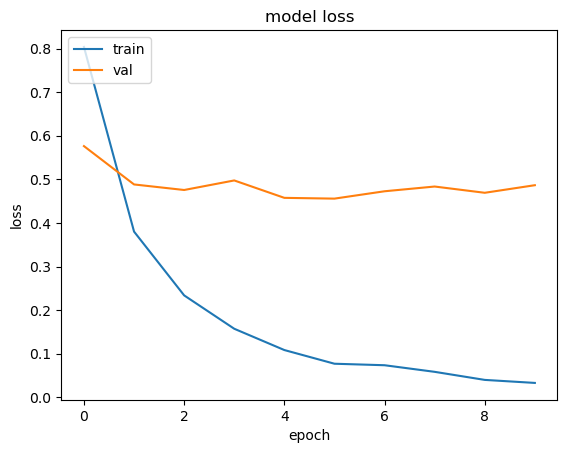

In [33]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','val'], loc='upper left')
plt.show()

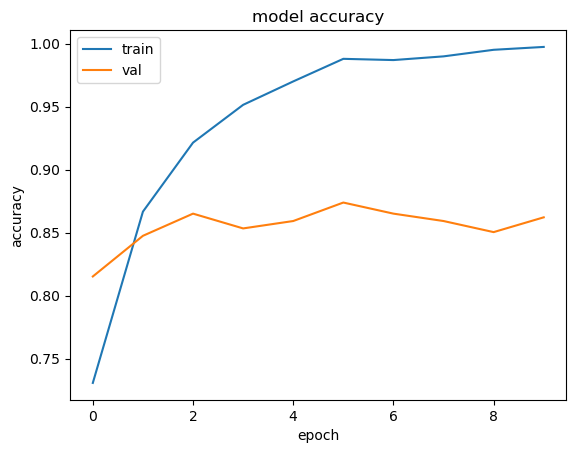

In [34]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','val'], loc='upper left')
plt.show()

We know we can use this model, but let us check with various learning rate and dropout rate. Let's create a model definition.

In [7]:
def make_model(learning_rate=0.001, droprate=0.2):
    base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2L(include_top=False, input_shape=(128,128,3))
    base_model.trainable = False

    # Whole Model

    inputs = tf.keras.Input(shape=(128,128,3))
    base = base_model(inputs, training=False)
    inner = tf.keras.layers.Conv2D(50, 3, activation='relu')(base)
    vector = tf.keras.layers.MaxPool2D()(inner)
    drop = tf.keras.layers.Dropout(droprate)(vector)
    flat = tf.keras.layers.Flatten()(drop)
    outputs = tf.keras.layers.Dense(10)(flat)

    model = tf.keras.Model(inputs, outputs)
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=["accuracy"])
    
    return model

In [8]:
# learning_rate=0.001, droprate=0.2

model = make_model(learning_rate=0.001, droprate=0.2)

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        "EfficientNetV2L_001_2.h5",
        monitor="val_accuracy",
        save_best_only=True,
        mode='max',
        verbose=1
    )
]

history_0 = model.fit(train_ds, epochs=10, validation_data=validation_ds, callbacks=callbacks)

Epoch 1/10
96/96 [==============================] - ETA: 0s - loss: 0.9603 - accuracy: 0.6998
Epoch 1: val_accuracy improved from -inf to 0.80938, saving model to EfficientNetV2L_001_2.h5
96/96 [==============================] - 185s 2s/step - loss: 0.9603 - accuracy: 0.6998 - val_loss: 0.5810 - val_accuracy: 0.8094
Epoch 2/10
96/96 [==============================] - ETA: 0s - loss: 0.5221 - accuracy: 0.8201
Epoch 2: val_accuracy improved from 0.80938 to 0.81232, saving model to EfficientNetV2L_001_2.h5
96/96 [==============================] - 157s 2s/step - loss: 0.5221 - accuracy: 0.8201 - val_loss: 0.5477 - val_accuracy: 0.8123
Epoch 3/10
96/96 [==============================] - ETA: 0s - loss: 0.3574 - accuracy: 0.8739
Epoch 3: val_accuracy improved from 0.81232 to 0.82698, saving model to EfficientNetV2L_001_2.h5
96/96 [==============================] - 161s 2s/step - loss: 0.3574 - accuracy: 0.8739 - val_loss: 0.5778 - val_accuracy: 0.8270
Epoch 4/10
96/96 [======================

In [9]:
# learning_rate=0.0001, droprate=0.2

model = make_model(learning_rate=0.0001, droprate=0.2)

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        "EfficientNetV2L_0001_2.h5",
        monitor="val_accuracy",
        save_best_only=True,
        mode='max',
        verbose=1
    )
]

history_1 = model.fit(train_ds, epochs=10, validation_data=validation_ds, callbacks=callbacks)

Epoch 1/10
96/96 [==============================] - ETA: 0s - loss: 1.0641 - accuracy: 0.6493
Epoch 1: val_accuracy improved from -inf to 0.80059, saving model to EfficientNetV2L_0001_2.h5
96/96 [==============================] - 205s 2s/step - loss: 1.0641 - accuracy: 0.6493 - val_loss: 0.5901 - val_accuracy: 0.8006
Epoch 2/10
96/96 [==============================] - ETA: 0s - loss: 0.5738 - accuracy: 0.8116
Epoch 2: val_accuracy improved from 0.80059 to 0.83871, saving model to EfficientNetV2L_0001_2.h5
96/96 [==============================] - 164s 2s/step - loss: 0.5738 - accuracy: 0.8116 - val_loss: 0.4945 - val_accuracy: 0.8387
Epoch 3/10
96/96 [==============================] - ETA: 0s - loss: 0.4497 - accuracy: 0.8527
Epoch 3: val_accuracy improved from 0.83871 to 0.85337, saving model to EfficientNetV2L_0001_2.h5
96/96 [==============================] - 164s 2s/step - loss: 0.4497 - accuracy: 0.8527 - val_loss: 0.4499 - val_accuracy: 0.8534
Epoch 4/10
96/96 [===================

In [10]:
# learning_rate=0.001, droprate=0.3

model = make_model(learning_rate=0.001, droprate=0.3)

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        "EfficientNetV2L_001_3.h5",
        monitor="val_accuracy",
        save_best_only=True,
        mode='max',
        verbose=1
    )
]

history_2 = model.fit(train_ds, epochs=10, validation_data=validation_ds, callbacks=callbacks)

Epoch 1/10
96/96 [==============================] - ETA: 0s - loss: 0.9836 - accuracy: 0.6926
Epoch 1: val_accuracy improved from -inf to 0.80059, saving model to EfficientNetV2L_001_3.h5
96/96 [==============================] - 210s 2s/step - loss: 0.9836 - accuracy: 0.6926 - val_loss: 0.5969 - val_accuracy: 0.8006
Epoch 2/10
96/96 [==============================] - ETA: 0s - loss: 0.5874 - accuracy: 0.8025
Epoch 2: val_accuracy improved from 0.80059 to 0.83284, saving model to EfficientNetV2L_001_3.h5
96/96 [==============================] - 179s 2s/step - loss: 0.5874 - accuracy: 0.8025 - val_loss: 0.5371 - val_accuracy: 0.8328
Epoch 3/10
96/96 [==============================] - ETA: 0s - loss: 0.4792 - accuracy: 0.8449
Epoch 3: val_accuracy improved from 0.83284 to 0.83578, saving model to EfficientNetV2L_001_3.h5
96/96 [==============================] - 171s 2s/step - loss: 0.4792 - accuracy: 0.8449 - val_loss: 0.5059 - val_accuracy: 0.8358
Epoch 4/10
96/96 [======================

In [11]:
# learning_rate=0.0001, droprate=0.3

model = make_model(learning_rate=0.0001, droprate=0.3)

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        "EfficientNetV2L_0001_3.h5",
        monitor="val_accuracy",
        save_best_only=True,
        mode='max',
        verbose=1
    )
]

history_3 = model.fit(train_ds, epochs=10, validation_data=validation_ds, callbacks=callbacks)

Epoch 1/10
96/96 [==============================] - ETA: 0s - loss: 1.2014 - accuracy: 0.6138
Epoch 1: val_accuracy improved from -inf to 0.76540, saving model to EfficientNetV2L_0001_3.h5
96/96 [==============================] - 237s 2s/step - loss: 1.2014 - accuracy: 0.6138 - val_loss: 0.7441 - val_accuracy: 0.7654
Epoch 2/10
96/96 [==============================] - ETA: 0s - loss: 0.6999 - accuracy: 0.7885
Epoch 2: val_accuracy improved from 0.76540 to 0.80352, saving model to EfficientNetV2L_0001_3.h5
96/96 [==============================] - 210s 2s/step - loss: 0.6999 - accuracy: 0.7885 - val_loss: 0.6178 - val_accuracy: 0.8035
Epoch 3/10
96/96 [==============================] - ETA: 0s - loss: 0.5370 - accuracy: 0.8263
Epoch 3: val_accuracy improved from 0.80352 to 0.80938, saving model to EfficientNetV2L_0001_3.h5
96/96 [==============================] - 186s 2s/step - loss: 0.5370 - accuracy: 0.8263 - val_loss: 0.5731 - val_accuracy: 0.8094
Epoch 4/10
96/96 [===================

We can see the best val_accuracy (0.86510) was achieved by learning_rate=0.0001, droprate=0.2, But let's check out the accuracy graph with different model too.

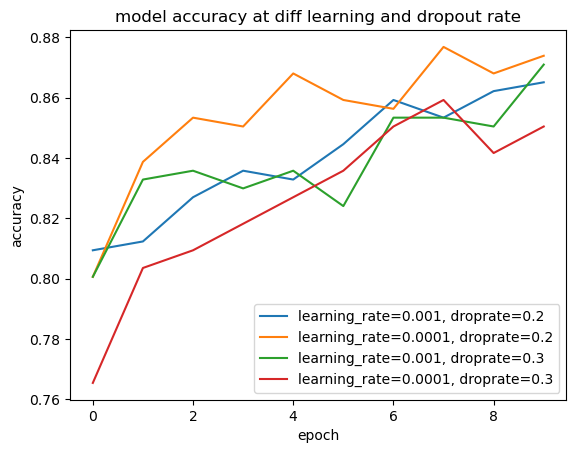

In [15]:
import matplotlib.pyplot as plt

plt.plot(history_0.history['val_accuracy'])
plt.plot(history_1.history['val_accuracy'])
plt.plot(history_2.history['val_accuracy'])
plt.plot(history_3.history['val_accuracy'])
plt.title('model accuracy at diff learning and dropout rate')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['learning_rate=0.001, droprate=0.2', 'learning_rate=0.0001, droprate=0.2', 'learning_rate=0.001, droprate=0.3', 'learning_rate=0.0001, droprate=0.3'], loc='lower right')
plt.show()

# Model with Data Augmentation

In [1]:
# Error handling

import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [2]:
import tensorflow as tf

In [3]:
image_size = (128,128)

In [4]:
train_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet_v2.preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    shear_range=0.2,
    zoom_range=0.2,
)

train_ds = train_gen.flow_from_directory(
    "clothing-dataset-small-master/train",
    target_size=image_size,
    seed=0,
)

Found 3068 images belonging to 10 classes.


In [5]:
validation_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet_v2.preprocess_input)

validation_ds = validation_gen.flow_from_directory(
    "clothing-dataset-small-master/validation",
    seed=0,
    target_size=image_size,
)

Found 341 images belonging to 10 classes.


In [6]:
def make_model(learning_rate=0.001, droprate=0.2):
    base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2L(include_top=False, input_shape=(128,128,3))
    base_model.trainable = False

    # Whole Model

    inputs = tf.keras.Input(shape=(128,128,3))
    base = base_model(inputs, training=False)
    inner = tf.keras.layers.Conv2D(50, 3, activation='relu')(base)
    vector = tf.keras.layers.MaxPool2D()(inner)
    drop = tf.keras.layers.Dropout(droprate)(vector)
    flat = tf.keras.layers.Flatten()(drop)
    outputs = tf.keras.layers.Dense(10)(flat)

    model = tf.keras.Model(inputs, outputs)
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=["accuracy"])
    
    return model

In [7]:
# learning_rate=0.0001, droprate=0.2

model = make_model(learning_rate=0.0001, droprate=0.2)

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        "EfficientNetV2L_{epoch:02d}_{val_accuracy:.3f}.h5",
        monitor="val_accuracy",
        save_best_only=True,
        mode='max',
        verbose=1
    )
]

history = model.fit(train_ds, epochs=10, validation_data=validation_ds, callbacks=callbacks)

Epoch 1/10
96/96 [==============================] - ETA: 0s - loss: 1.3141 - accuracy: 0.5574
Epoch 1: val_accuracy improved from -inf to 0.75073, saving model to EfficientNetV2L_01_0.751.h5
96/96 [==============================] - 211s 2s/step - loss: 1.3141 - accuracy: 0.5574 - val_loss: 0.6956 - val_accuracy: 0.7507
Epoch 2/10
96/96 [==============================] - ETA: 0s - loss: 0.8326 - accuracy: 0.7141
Epoch 2: val_accuracy improved from 0.75073 to 0.79179, saving model to EfficientNetV2L_02_0.792.h5
96/96 [==============================] - 172s 2s/step - loss: 0.8326 - accuracy: 0.7141 - val_loss: 0.5837 - val_accuracy: 0.7918
Epoch 3/10
96/96 [==============================] - ETA: 0s - loss: 0.7417 - accuracy: 0.7487
Epoch 3: val_accuracy improved from 0.79179 to 0.81232, saving model to EfficientNetV2L_03_0.812.h5
96/96 [==============================] - 164s 2s/step - loss: 0.7417 - accuracy: 0.7487 - val_loss: 0.5342 - val_accuracy: 0.8123
Epoch 4/10
96/96 [=============

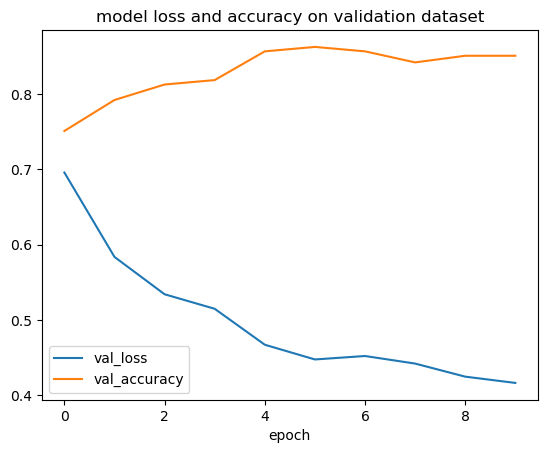

In [9]:
import matplotlib.pyplot as plt

plt.plot(history.history['val_loss'])
plt.plot(history.history['val_accuracy'])
plt.title('model loss and accuracy on validation dataset')
plt.xlabel('epoch')
plt.legend(['val_loss', 'val_accuracy'], loc='lower left')
plt.show()